# Creating Lists of Words Related to a Specified Search Term

## This algorithm provides the following:
- Imports a dataframe of tweets
- Processes tweets and tokenizes words
- Uses Word Embeddings to convert words into vectors
- Determines related words by using cosine similarity within the vector space
- Generates a list, or lists, of words within the time delta(s) selected, ordered by min-maxed cosine similarity.

### Imported Libraries
Libraries and modules below are used to import and process the tokens into vectors, removing extraneous words.

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from math import ceil
import string
import re

### Tweet Import
Importing and parsing tweets into dataframe, converting the datestamp strings to datetime objects.

In [2]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

### Isolating Tweets by language (english)


In [3]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

### Text Cleaning and Tokenization Functions

In [4]:
tweet_stops = stopwords.words('english')
tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

def clean_tweet(tweet):
#     takes input string and converts or removes characters depending on settings.
#     returns a string
#     convert case:
    tweet = tweet.lower()
#     remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
#     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
#     remove punctuation, but not hashtags:
    tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
#     remove non-hashtag '#'.
    tweet = re.sub('#\B','',tweet)
#     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
#     drop numbers and words of < 4 characters.
    tweet = re.sub(r'\b\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_as_tokens = tweet_tokenizer.tokenize(cleaned_tweet)
    tweet_no_stops = [word for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

### Search Term
This is the term that will serve as the comparison for all later lists.

In [114]:
search_term = "irma"

### Related Words Dataframe and Time Deltas
This instantiates the dataframe for the related words and specifies the start, end, and time delta for the periods of related words.

In [115]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

### Related Word list quantity
This number specifies the number of words that will be returned in each list associated with the time periods specified above

In [116]:
top_num_words = 300

## Word Embeddings
### Converting Words to Vectors using the 'Word2Vec' library

- Iterate through each time period designated above
- Apply the tokenization and cleaning functions
- Convert the tokens to vectors using the following:
    - Minimum count = 1
    - Skip-Gram
    - Window of 3
    - 100D vectors

In [117]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]

    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=11, workers=1, size=100, seed=1, sg=1)
    word_matrix = vector_model.wv[vector_model.wv.vocab]

    terms_from_range = pd.DataFrame.from_records(vector_model.wv.most_similar(search_term,topn=top_num_words),
                                                 columns=[tweet_day,"score"])

    related_words = pd.concat([related_words,terms_from_range],axis=1)

### MinMax Scaling on Cosine Similarity Values
Convert the cosine similarity to min-maxed value

In [118]:
cos_sim_values = related_words.iloc[:,1::2]

In [119]:
related_words.iloc[:,1::2] = (cos_sim_values - cos_sim_values.min())* 100 / (cos_sim_values.max() - cos_sim_values.min())

In [120]:
related_words.head(5)

,2017-09-10 00:00:00,score
0,waiting,100.000000
1,away,88.847305
2,pass,87.409633
3,category,78.739670
4,little,76.723000


## Identifying Relationships with Human Coded Data

### Using the list of related words to identify an Irma Related tweet.

Importing a list of human coded tweets for 'irma related'

In [121]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

The counts of human coded Irma related tweets: 0 = not related, 1 = 'irma' related

In [122]:
hc_encoded_counts = tweet_encoded.loc[:,['tweet_id','timestamp','irma_rel','tweet_text']].groupby('irma_rel').size()
print(hc_encoded_counts)

irma_rel
0    10792
1     8296
dtype: int64


In [123]:
related_words[related_words.score > 98]

,2017-09-10 00:00:00,score
0,waiting,100.0


This function takes a numeric score as an input. From there it:
- finds all of the words whose cosine similarity min-maxed for the range are greater than the 'score'.
- creates a list of those words.
- appends the search term to that list.
- converts that list to a pipe-delimited string.

This pipe-delimited string can be used as the input of the `pd.Series.str.contains()` method as a regular expression for matching rows who contain one or more of the terms.

In [124]:
def WordsScoreGreater(score):
    related_word_list = list(related_words[related_words.iloc[:,1] > score].iloc[:,0])
    related_word_list.append(search_term)
    return "|".join(related_word_list)

For purposes of evaluating the effectiveneness of the related words threshold, there are 4 categories of tweets:
- human-coded 'irma-related' and the word list is a match (true positive)
- human-coded 'not irma-related' and the word list is a match (false positive)
- human-coded 'irma-related' and the word list is not a match (false negative)
- human-coded 'not irma-related' and the word list is not a match (true negative)

The dataframe here acts as a confusion matrix for integer thresholds of the related words scores.

In [125]:
score_matrix = pd.DataFrame()

In [126]:
for i in list(range(100,0,-1)):
    score_entries = pd.Series([i,
               len(tweet_encoded[(tweet_encoded.tweet_text.str.contains(WordsScoreGreater(i),flags=re.IGNORECASE)) & (tweet_encoded.irma_rel == 1)]),
               len(tweet_encoded[(tweet_encoded.tweet_text.str.contains(WordsScoreGreater(i),flags=re.IGNORECASE)) & (tweet_encoded.irma_rel == 0)]),
               len(tweet_encoded[~(tweet_encoded.tweet_text.str.contains(WordsScoreGreater(i),flags=re.IGNORECASE)) & (tweet_encoded.irma_rel == 1)]),
               len(tweet_encoded[~(tweet_encoded.tweet_text.str.contains(WordsScoreGreater(i),flags=re.IGNORECASE)) & (tweet_encoded.irma_rel == 0)])]
            )
    score_matrix = score_matrix.append(score_entries,ignore_index=True)

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
col_names = ['val','TruePos','FalsePos','FalseNeg','TrueNeg']
score_matrix.columns = col_names

In [134]:
score_matrix.head(10)

,val,TruePos,FalsePos,FalseNeg,TrueNeg
0,100.0,4416.0,256.0,3880.0,10536.0
1,99.0,4443.0,288.0,3853.0,10504.0
2,98.0,4443.0,288.0,3853.0,10504.0
3,97.0,4443.0,288.0,3853.0,10504.0
4,96.0,4443.0,288.0,3853.0,10504.0
5,95.0,4443.0,288.0,3853.0,10504.0
6,94.0,4443.0,288.0,3853.0,10504.0
7,93.0,4443.0,288.0,3853.0,10504.0
8,92.0,4443.0,288.0,3853.0,10504.0
9,91.0,4443.0,288.0,3853.0,10504.0


In the chart below, an increase in x represents a longer list of words whose inclusion would indicate an 'irma-related' tweet within the model. By allowing more words into this list, there is a larger number of tweets evaluated as a true positive result, but it also increases the false positives. The objective is to maximize the number of true positives, while minimizing false positives.

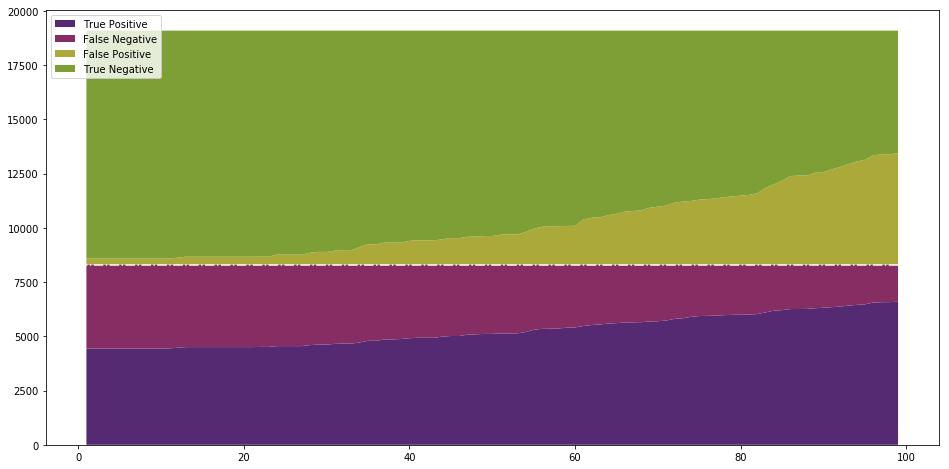

In [133]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots()

color_list = ["#562a72", "#862d63", "#aaa939", "#7e9f35"]

ax.stackplot(score_matrix.iloc[1:,:].index, 
             score_matrix.iloc[1:,:].TruePos, 
             score_matrix.iloc[1:,:].FalseNeg, 
             score_matrix.iloc[1:,:].FalsePos, 
             score_matrix.iloc[1:,:].TrueNeg,
             labels=["True Positive","False Negative","False Positive","True Negative"],
            colors = color_list)
ax.axhline(hc_encoded_counts[1],linestyle="-.",color="w")
ax.legend(loc='upper left')
plt.show()

In [136]:
print(score_matrix.iloc[ceil(related_words.iloc[50].score)])

val           61.0
TruePos     4877.0
FalsePos    1029.0
FalseNeg    3419.0
TrueNeg     9763.0
Name: 39, dtype: float64


In [132]:
score_matrix.iloc[[ceil(related_words.iloc[i].score) for i in [20,50,75,100,150,200,250,299]]]

,val,TruePos,FalsePos,FalseNeg,TrueNeg
57,43.0,5351.0,1764.0,2945.0,9028.0
39,61.0,4877.0,1029.0,3419.0,9763.0
32,68.0,4663.0,674.0,3633.0,10118.0
27,73.0,4549.0,470.0,3747.0,10322.0
17,83.0,4503.0,373.0,3793.0,10419.0
12,88.0,4472.0,331.0,3824.0,10461.0
6,94.0,4443.0,288.0,3853.0,10504.0
0,100.0,4416.0,256.0,3880.0,10536.0


In [155]:
hc_pos = hc_encoded_counts[1]
for i in list(range(100,0,-10)):
    print("related words above "+str(i)+"%: "+ str(score_matrix.iloc[ceil(related_words.iloc[i].score),1])+" / "+str(hc_pos) )

related words above 100%: 4549.0 / 8296
related words above 90%: 4619.0 / 8296
related words above 80%: 4652.0 / 8296
related words above 70%: 4716.0 / 8296
related words above 60%: 4857.0 / 8296
related words above 50%: 4877.0 / 8296
related words above 40%: 5014.0 / 8296
related words above 30%: 5110.0 / 8296
related words above 20%: 5351.0 / 8296
related words above 10%: 5646.0 / 8296
